In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name,asym=True):
        Z=np.mean(W)
        err=np.abs(Z-1)
        if asym:
            aVar=np.var(W)
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum((W/np.sum(W))**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}'\
                  .format(name,Z,err,aVar,aErr,ESS,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,Z,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('------------ pdf ratio at origin: {:.2f} ------------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(np.zeros([1,self.dim]))[0]
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','nonparametric proposal','mixture proposal','centers','centers with weight'])
        elif name=='regression':
            G=self.G(X)
            rPO=self.regO.coef_.dot(G)+self.regO.intercept_*P(X)
            rPL=self.regL.coef_.dot(G)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        if(type(bdwth)==str):
            method=bdwth
            tmp=sciKDE(self.rS.T,bw_method=method)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f} (based on {})'.format(bdwth,method))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        def G(x):
            tmp=np.array([self.h(x,loc) for loc in self.rSset])
            return tmp[1:]-tmp.mean(axis=0)

        self.G=G
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,alpha,vif=False):
        X=(self.G(self.S)/self.mP(self.S)).T
        if vif:
            if X.shape[1]<=100:
                ind=np.arange(X.shape[1])
            else:
                ind=np.random.choice(np.arange(X.shape[1]),100,replace=False)

            tmp=np.hstack([X,np.ones([X.shape[0],1])])
            Vif=np.zeros(ind.size)
            for i in range(ind.size):
                Vif[i]=VIF(tmp,ind[i])

            print('VIF: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>5] {}/{})'\
                  .format(Vif.min(),np.median(Vif),Vif.mean(),Vif.max(),np.sum(Vif>5),Vif.size))
        
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ordinary R2: {:.4f}; Lasso R2: {:.4f}'.format(self.regO.score(X,y),self.regL.score(X,y)))
        
        W=y-X.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord)')
        W=y-X.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las)')
    
    def estimate_MLE(self,opt=False):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

IS est: 1.0158; err: 0.0158; a-var: 32.1492; a-err: 0.0401; ESS: 622/20000
------------ pdf ratio at origin: 256.00 ------------


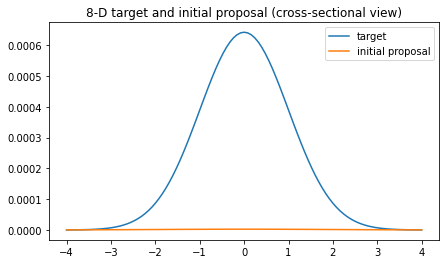

resampling rate: 407/500
bdwth: 0.7800 (based on scott)
NIS est: 0.9976; err: 0.0024; a-var: 1.1890; a-err: 0.0077; ESS: 9112/20000
MIS est: 0.9905; err: 0.0095; a-var: 1.3608; a-err: 0.0082; ESS: 8379/20000
------------ pdf ratio at origin: 8.43 ------------


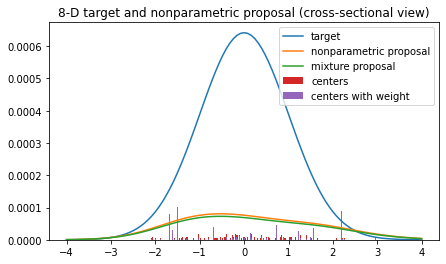

VIF: (min 1.4483, median 1.8386, mean 1.8773, max 3.2315, [>5] 0/100)
Ordinary R2: 0.7181; Lasso R2: 0.6952
RIS(Ord) est: 0.9963; err: 0.0037; a-var: 0.3836; a-err: 0.0044; ESS: 14425/20000
RIS(Las) est: 0.9964; err: 0.0036; a-var: 0.4147; a-err: 0.0046; ESS: 14107/20000
------------ pdf ratio at origin: 9.33 ------------
regression ratios: ordinary 1.8398, lasso 1.9766


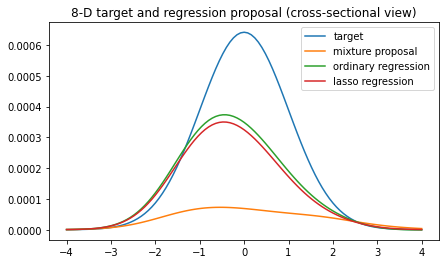

Reference:
origin: value: 13.6153; grad: (min -0.3589, mean 0.0002, max 0.3978, std 0.0868)

Theoretical results:
MLE(The) zeta: (min -0.0061, mean -0.0002, max 0.0064, std 0.0012, norm 0.0252)
theory: value: nan; grad: (min -0.3818, mean 0.0000, max 2.6971, std 0.1520)
RIS(The) est: 0.9963; err: 0.0037
MLE(The) est: 0.9854; err: 0.0146

Optimization results (spent 1 seconds):
MLE(Opt) zeta: (min -0.0062, mean -0.0002, max 0.0056, std 0.0013, norm 0.0258)
Dist(zeta(Opt),zeta(The))=0.0058
optimal: value: nan; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9945; err: 0.0055


In [4]:
np.random.seed(12345678)
mle=MLE(dim=8,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(500,50)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1,vif=True)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)